#**AI@UChicago - Language Models - Lesson 1: Attention**#

## **Section 1: A little game**

### **1.1: Fill in the Blank**

To first understand large language models, we mist first understand **attention**.

Consider: Hung tried to sleep but his [MASK] was too loud.

What is "[MASK]"?  

Maybe these sentences are easier:

*   Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.
*   Hung tried to sleep, but his [MASK] kept barking at nothing.
*   Hung tried to sleep, but his [MASK] kept ringing.


Why are these easier?





### **1.2: Machines can also play this game**

In [ ]:
%%capture
# DON'T WORRY ABOUT THIS STUFF NOW, WE WILL GET TO IT LATER!
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

def predict_word(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt")

    # Find the position of the [MASK] token
    mask_token_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)[0]

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted token probabilities
    logits = outputs.logits
    mask_token_logits = logits[0, mask_token_index, :]

    # Get the top 3 tokens
    top_3_tokens = torch.topk(mask_token_logits, 3, dim=1)

    # Print the results
    print(f"\nSentence: {sentence}")
    print("Top 3 predictions:")
    for i, (token_id, prob) in enumerate(zip(top_3_tokens.indices[0], top_3_tokens.values[0])):
        token = tokenizer.decode([token_id])
        probability = torch.softmax(mask_token_logits, dim=1)[0, token_id].item()
        print(f"{i+1}. {token:<10} (Probability: {probability:.4f})")

In [ ]:
sentences = [
    "Hung tried to sleep but his [MASK] was too loud.",
    "Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.",
    "Hung tried to sleep, but his [MASK] kept barking at nothing.",
    "Hung tried to sleep, but his [MASK] kept ringing."
]

for sentence in sentences:
    predict_word(model, tokenizer, sentence)


Sentence: Hung tried to sleep but his [MASK] was too loud.
Top 3 predictions:
1. voice      (Probability: 0.1935)
2. breathing  (Probability: 0.0887)
3. dream      (Probability: 0.0768)

Sentence: Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.
Top 3 predictions:
1. father     (Probability: 0.2311)
2. dad        (Probability: 0.2033)
3. brother    (Probability: 0.1520)

Sentence: Hung tried to sleep, but his [MASK] kept barking at nothing.
Top 3 predictions:
1. dog        (Probability: 0.4576)
2. mother     (Probability: 0.0553)
3. stomach    (Probability: 0.0393)

Sentence: Hung tried to sleep, but his [MASK] kept ringing.
Top 3 predictions:
1. ears       (Probability: 0.6666)
2. phone      (Probability: 0.2349)
3. head       (Probability: 0.0517)


### **1.3: How machines play**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

def strip_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def show_weights(model, tokenizer, sentence, exclude = True):
    # Strip punctuation and tokenize the input sentence
    stripped_sentence = strip_punctuation(sentence)
    inputs = tokenizer(stripped_sentence, return_tensors="pt")

    # Get the attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Get the attention weights from the last layer
    attention = outputs.attentions[-1].squeeze()

    # Average the attention across all heads
    attention = attention.mean(dim=0)

    # Get the tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Find the positions of [CLS] and [SEP] tokens
    cls_position = tokens.index('[CLS]')
    sep_position = tokens.index('[SEP]')

    # Remove the [CLS] and [SEP] tokens from tokens and attention matrix
    attention = attention.numpy()
    if exclude:
        tokens = tokens[cls_position+1:sep_position]
        attention = np.delete(attention, [cls_position, sep_position], axis=0)
        attention = np.delete(attention, [cls_position, sep_position], axis=1)

    # Renormalize the attention weights
    attention = attention / attention.sum(axis=-1, keepdims=True)

    # Create a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(attention, cmap="YlOrRd", annot=False,
                xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Attention weights matrix for:\n{sentence}")
    plt.xlabel("Key Tokens (attended to)", fontsize=12)
    plt.ylabel("Query Tokens (attending)", fontsize=12)

    plt.tight_layout()
    plt.show()

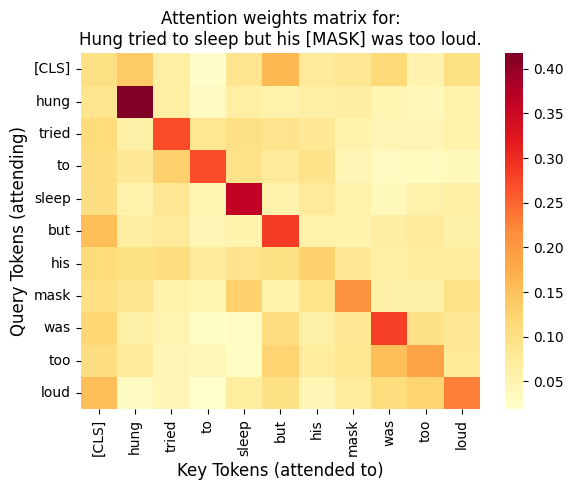

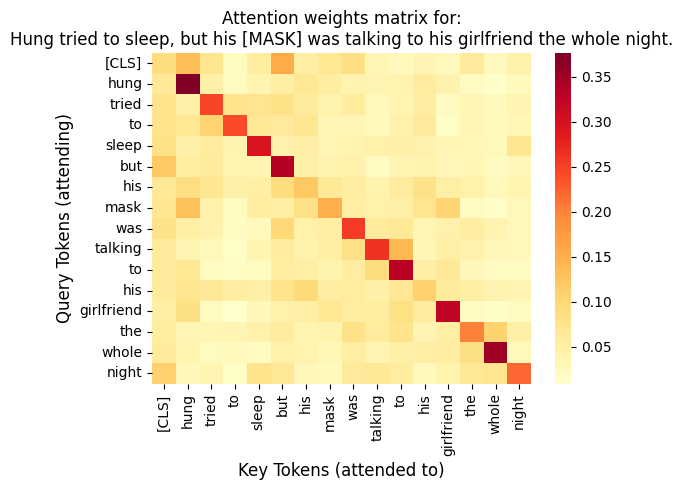

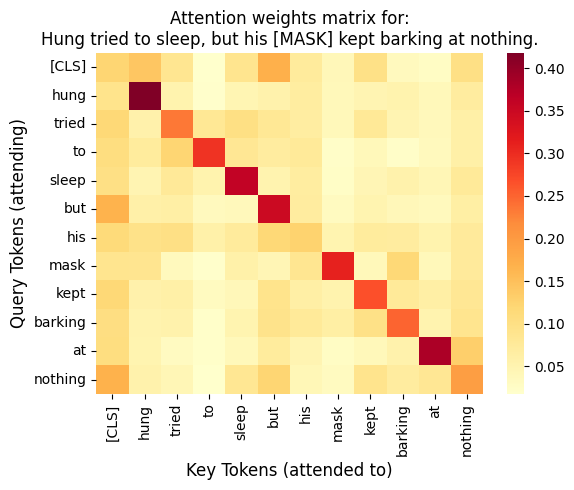

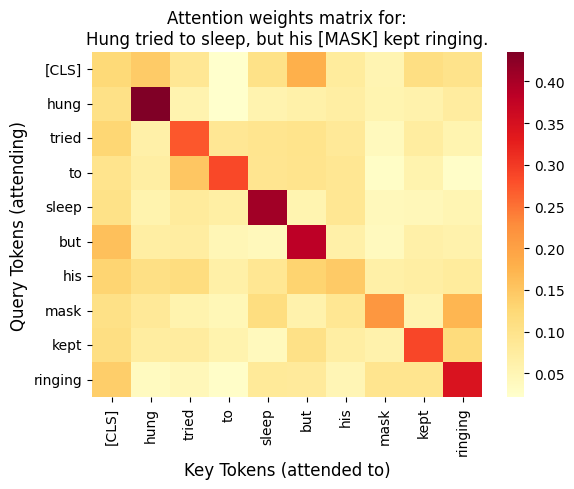

In [ ]:
for sentence in sentences:
    show_weights(model, tokenizer, sentence)

**Note:**
Models actually learn attention by playing this game of "guess the token" and backpropogating towards the ground truth answer.

## **Section 2: Queries, Keys, and Values**

### **2.1: Intuition for QKV**

**Note:** there are other kinds of attention mechanisms, but or sake of time, we will only pay attention to the one that are widely used in LLMs.

The kind we will be looking at is called **"scaled dot product attention"**.

At the heart of scaled dot product attention are keys (K), queries (Q), and values (V).

In [ ]:
# If you know python, you're already familiar with some version of QKV: dictionaries

Q = "K2"

D = {
    "K1": "V1",
    "K2": "V2",
    "K3": "V3"
}

print(D[Q])

V2


### **2.2: Attention by QKV: the math**

In attention, though, we care more about how *well* a query fits with a particular key, which will determine the how we weight the corresponsing value.

Let's say that we have a sentence of length $n$ tokens.  Tokens can be thought of as words, but note that some words are made of multiple tokens.

Naturally, that means we'd want $n$ keys and $n$ corresponsding values.  In natural language processing (NLP), pretty much everything is a vector because we can encode complex linguistic relationships in high dimentional vectors.

Suppose:

*   $n$ query vectors $q_i$, with dimension $d_q$
*   $n$ key vectors, $k_i$, with dimension $d_q$
*   $n$ corresponsing value vectors, $v_i$, with dimension $d_v$

Note that we don't necessarily need $d_q = d_v$, but we abolutely need the key and query vectors to be the same dimension.

Then we end up having
*   Query matrix $Q \in \mathbb{R}^{n \, \times \, d_q }$
*   Key matrix $K \in \mathbb{R}^{n \, \times \, d_q }$
*   Value matrix $V \in \mathbb{R}^{n \, \times \, d_v }$

In order to understand the compatibility between the queries and keys, we need to multiply the matricies, which we do by $QK^T$.

We normalize this value by dimension since if we increase the dimension, the values in $QK^T$ can get arbitrarily large.

Thus we have $\frac{QK^T}{\sqrt{d_q}} \in \mathbb{R}^{n \, \times \, n }$.

We're still not done with normalizaiton, though, as we want to make sure that the values in each row are normalized and positive.  To accomplish this, we use a probability distribuiton tool called "softmax", denoted $\sigma:\mathbb{R}^n \rightarrow (0, 1]^n$.

$$\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{n}exp(z_j)}$$

We apply softmax row-wise to obtain: $$\sigma(\frac{QK^T}{\sqrt{d_q}})\in \mathbb{R}^{n \, \times \, n }$$.

Now, all rows add to one and are positive.  Does this seem familiar?

Lastly, it's a simple step to perform matrix multiplication with $V$, which essentially tells us how *important* each connection is, while $\sigma(\frac{QK^T}{\sqrt{d_q}})$ tells us how *strong* the connection is.

So, finally, we get: $$Attention(Q, K, V) = \sigma(\frac{QK^T}{\sqrt{d_q}})V \in \mathbb{R}^{n \, \times \, d_v }$$

**This is our formula for scaled dot product attention.**

### **2.3: Attention by QKV: the code for $\sigma(\frac{QK^T}{\sqrt{d_q}})$**

In [ ]:
# Let's code it
from transformers import BertModel, BertTokenizer
import math

class Attention:
    def __init__(self, model,  tokenizer):
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def get_QK_T(self, sentence: str):
        tokens = self.tokenizer.tokenize(sentence)
        print("Tokens:", tokens)

        ids = []

        for token in tokens:
            id = self.tokenizer.convert_tokens_to_ids(token)
            ids.append(id)

        print("How the computer sees the tokens", ids)

        d_q = 1

        input_ids = torch.tensor(ids).unsqueeze(0)
        with torch.no_grad():
            outputs = self.model(input_ids)
            embeddings = outputs.last_hidden_state[0]
        print("Vector representation dimensions:", len(embeddings),"by", len(embeddings[0]))

        d_q = len(embeddings[0])

        print("\nHere, we're going to be a bit cheap and set Q and K as the same vector reprentation. \nThis is NOT how it's done in the field, which we'll see next class.")

        Q = embeddings
        K_T = torch.transpose(embeddings, 0, 1)

        QK = torch.matmul(Q, K_T)

        print("")

        return QK, d_q

    def normalize_QK_T(self, QK_T, d_q):
        div_d_q = torch.div(QK_T, math.sqrt(d_q))

        softmaxed = torch.nn.functional.softmax(div_d_q, 0)

        return softmaxed


In [ ]:
s = "You are the key to my query"

attn = Attention(model, tokenizer)

QK_T, d_q = attn.get_QK_T(s)

print("Q(K^T) dimension:", QK_T.size())
print("Q(K^T):\n", QK_T)

N = attn.normalize_QK_T(QK_T, d_q)

print("\nNormalized Q(K^T):\n", N)


Tokens: ['you', 'are', 'the', 'key', 'to', 'my', 'query']
How the computer sees the tokens [2017, 2024, 1996, 3145, 2000, 2026, 23032]
Vector representation dimensions: 7 by 768

Here, we're going to be a bit cheap and set Q and K as the same vector reprentation. 
This is NOT how it's done in the field, which we'll see next class.

Q(K^T) dimension: torch.Size([7, 7])
Q(K^T):
 tensor([[145.2904, 124.2025, 107.2782, 107.7140,  93.5499,  96.8252, 102.4099],
        [124.2025, 150.7934, 124.4207, 121.7916, 106.7936,  96.2314, 104.9211],
        [107.2782, 124.4207, 171.6270, 124.5788, 114.1441,  91.9515,  91.5665],
        [107.7140, 121.7916, 124.5788, 142.7945, 119.0422, 103.7349, 114.3812],
        [ 93.5499, 106.7936, 114.1441, 119.0422, 144.4766, 112.0527, 111.1005],
        [ 96.8252,  96.2314,  91.9515, 103.7349, 112.0527, 160.0919, 132.1034],
        [102.4099, 104.9211,  91.5665, 114.3812, 111.1005, 132.1034, 153.2335]])

Normalized Q(K^T):
 tensor([[0.3968, 0.1443, 0.0577, 0.085

In [ ]:
def create_heatmap(tensor, sentence, tokenizer, title="Heatmap"):
    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence)

    # Convert tensor to numpy array
    if isinstance(tensor, torch.Tensor):
        matrix = tensor.detach().cpu().numpy()
    else:
        matrix = np.array(tensor)

    # Ensure the matrix is 2D
    if matrix.ndim == 1:
        matrix = matrix.reshape(1, -1)

    # Trim or pad the matrix to match the number of tokens
    n_tokens = len(tokens)
    if matrix.shape[0] > n_tokens:
        matrix = matrix[:n_tokens, :n_tokens]
    elif matrix.shape[0] < n_tokens:
        pad_width = ((0, n_tokens - matrix.shape[0]), (0, n_tokens - matrix.shape[1]))
        matrix = np.pad(matrix, pad_width, mode='constant', constant_values=0)

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=False, cmap="YlOrRd", xticklabels=tokens, yticklabels=tokens)

    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

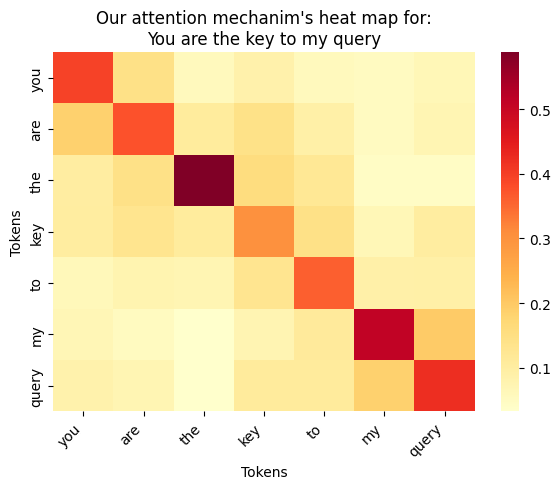

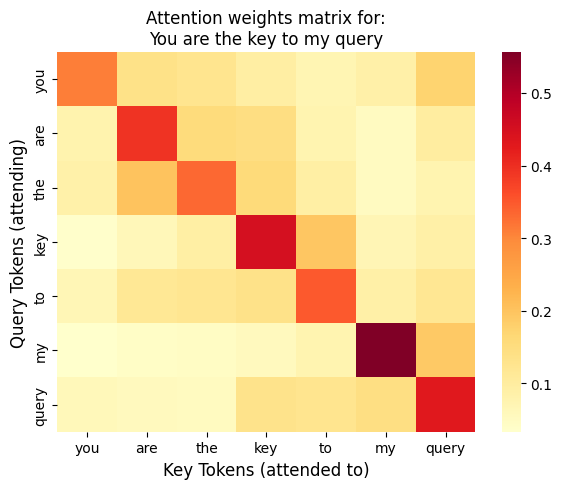

In [ ]:
create_heatmap(N, s, attn.tokenizer, title=f"Our attention mechanim's heat map for:\n{s}")
show_weights(attn.model, attn.tokenizer, s)

We can see that they share similar patterns, but they aren't identical.

One of the reasons that these aren't identical is that we actually didn't have certain special tokens, like [SEP] or [CLS] in our attention calculations that
the model we used - BERT - actually attends to.  The way I made 'show_weights' was to exclude them, but here is the *true* attention of the sentence:

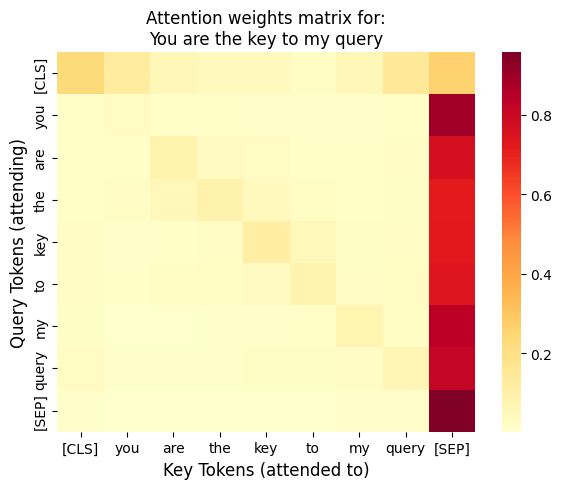

In [ ]:
show_weights(attn.model, attn.tokenizer, s, exclude=False)

You can kind of see why I chose to leave it out at the beggining.  The [SEP] token marks the end of a sentence or sequence, and as such, BERT has learned that it's very important to each token because the sentences archicatecture is havily dependant on it.

### **2.4: Conclusion of QKV**

That's most of the hard work done.

If you're asking why I'm not implementing the matrix multiplicaiton of $V$ at the end, it's becasue the values matrix is something that must be *learned*.  In practice, we'd need to learn $Q$ and $K$ too, but we improvised/estimated those values to demonstrate how the math works.

I'll end with a graphic used to desribe attention in the original paper, "[Attention is all you need](https://arxiv.org/pdf/1706.03762)".

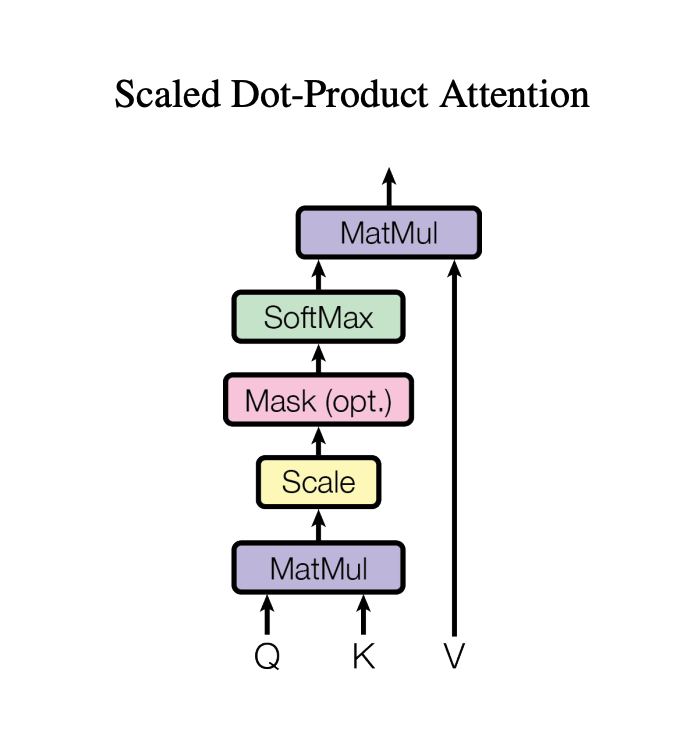

## **Section 3: Multi-head attention (MHA)**

### **3.1: Intuition for multi-head attention**

One node of attention, i.e. one $\sigma(\frac{QK^T}{\sqrt{d_q}})V$, is called one attention head. Why have one when you can have multiple, though?

Researches have found that performance increases when we linearly project the input down to certain learned features.  

More concretely, we have low dimension weight matricies of that represent certain features to pay attention to.  We don't know what there features are a priori - the weight matrices are learned during training.

However, if we multiply our input by the weight matrices (which, in linear algebra terms, could be called a projection), we end up getting many different matrices, which we then use QKV attention with.  Each one of these operations is called an attention head.

At the end, we take those outputs of each head and just stick them together, thereby acheiving multi-head attention.



### **3.2: The math for multi-head attention**

We start with an input matrix $\: X \in \mathbb{R}^{n \: \times \: d_{model}}$ where $n$ is the sequence length and $d_{model}$ is the embedding length, or the dimension of the vector representation of each token.

Let $h$ be the number of attention heads that we're dealing with.  We'd want $d_{model} % h = 0$ becasue we define $d_{head} = \frac{d_{model}}{h}$.

$d_{head}$ is the dimension that we want to project down to for each head.  We reduce the dimension for each head since it is computationally less expenive while not sacrificing performance.

We have three lists of weights:
*   Queries: $\{W_1^Q ,..., W_h^Q\} \: s.t. \: W_i^Q \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$
*   Keys: $\{W_1^K ,..., W_h^K\} \: s.t. \: W_i^K \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$
*   Values: $\{W_1^V ,..., W_h^V\} \: s.t. \: W_i^V \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$

At this point, it's worth noting the two different ways which MHA is often explained and implemented.  I will show you both and you can think of MHA in whichever way makes more sense to you.

#### **3.2.1: Many matrix MHA**

Given how I've set the theory up, this method seems more intuitive to me.

We continue by finding the queries, keys, and values for each attention head in the way you'd expect:
$$Q_i = XW_i^Q \in \mathbb{R}^{n \: \times \: d_{head}}$$
$$K_i = XW_i^K \in \mathbb{R}^{n \: \times \: d_{head}}$$
$$V_i = XW_i^V \in \mathbb{R}^{n \: \times \: d_{head}}$$

so that we can now define $head_i = Attention(Q_i, K_i, V_i) \in \mathbb{R}^{n \: \times \: d_{head}}$

and Multi head attention as $$matmul(concat(head_1, ..., head_h), W^O)$$

where $W^O \in \mathbb{R}^{h*d_{head} \: \times \: d_{model}}$ is a weight matrix designed to scale the output back to $\mathbb{R}^{n \: \times \: d_{model}}$

#### **3.2.2: One big matrix**

Another way that MHA is set up in pactice and theory is having one big matrix got Q, K, V rather than $h$ different ones.

We can do that by having large weight matrices:

*   $W^Q \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$
*   $W^K \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$
*   $W^V \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$

Whch means:

*   $Q = X W^Q \in \mathbb{R}^{n \: \times \: h*d_{head}}$
*   $K = X W^K \in \mathbb{R}^{n \: \times \: h*d_{head}}$
*   $V = X W^V \in \mathbb{R}^{n \: \times \: h*d_{head}}$

So then we can do: $$MultiHeadAttention(Q, K, V) = matmul(Attention(Q, K, V), \: W^O)$$

Where again, $W^O \in \mathbb{R}^{h*d_{head} \: \times \: d_{model}}$ servers to return the multi-head attention back to $\mathbb{R}^{n \: \times \: d_{model}}$ as somewhat of a re-normalization.

#### **3.2.3: Pros and cons**

Your choice to use either version of HMA depends on first and foremost, your understanding of each.  They are mathematically equivalent and theoretically provide no difference.

In practice, you're honestly never even going to touch attention, but if you ever do need to implement it, you should pick based on your resoruces.


**Low RAM:** If you have low memory, multiple little heads are better since there are less calculations that need to be done all at once.  Consequently, you will be forced to perform all those matrix operations sequentially which will take a lot of time.

**High RAM:**. If you have memory to spare, the large matrix multiplication consumes a lot of RAM, but it will be done much quicker since it takes $h$ times fewer operations.

Again, you will probably never actually care about which type of multu-head attention you're using, nor will you usually know.  I just had us think of these things becasue in ML (and CS in general), one has to constantly make decisions about speed vs compute.

## **Closing Remarks**

Attention is one of those concepts that, unless you're building or engineering language models, or unless it's your line of research, you're not going to come face to face with often.

It is, however, the fundamental building block of the **transformer**, the architecture of all modern LLMs and the subject of our next lecture, where we will discuss how transformers work and what makes them so great.



---



Written and developed in Summer 2024 by

*   Arjun Sohur
*   Hung Le Tran
*   AI@UChicago leadership team


**References and further learning**


*   Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 6000–6010. [link](https://https://arxiv.org/abs/1706.03762)
*   The Illustrated Transformer: https://jalammar.github.io/illustrated-transformer/
*    Implementionation: https://github.com/hyunwoongko/transformer
*    https://www.youtube.com/watch?v=iDulhoQ2pro

Reach out to suggest more!


